# Part 1: Data Preparation and Exploration

In [1]:
# Install pmdarima if not already installed
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.1 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set plot styles
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 300
sns.set_style('darkgrid')

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/snehuuu28/Excelr_Data_Science/main/Assignments/Assignment_20/exchange_rate.csv", index_col=0, parse_dates=True)

In [5]:
df

,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB


In [7]:
df.isnull().sum()

,0
Ex_rate,0


In [8]:
# Convert index to datetime
df.index = pd.to_datetime(df.index, format='%d-%m-%Y %H:%M')

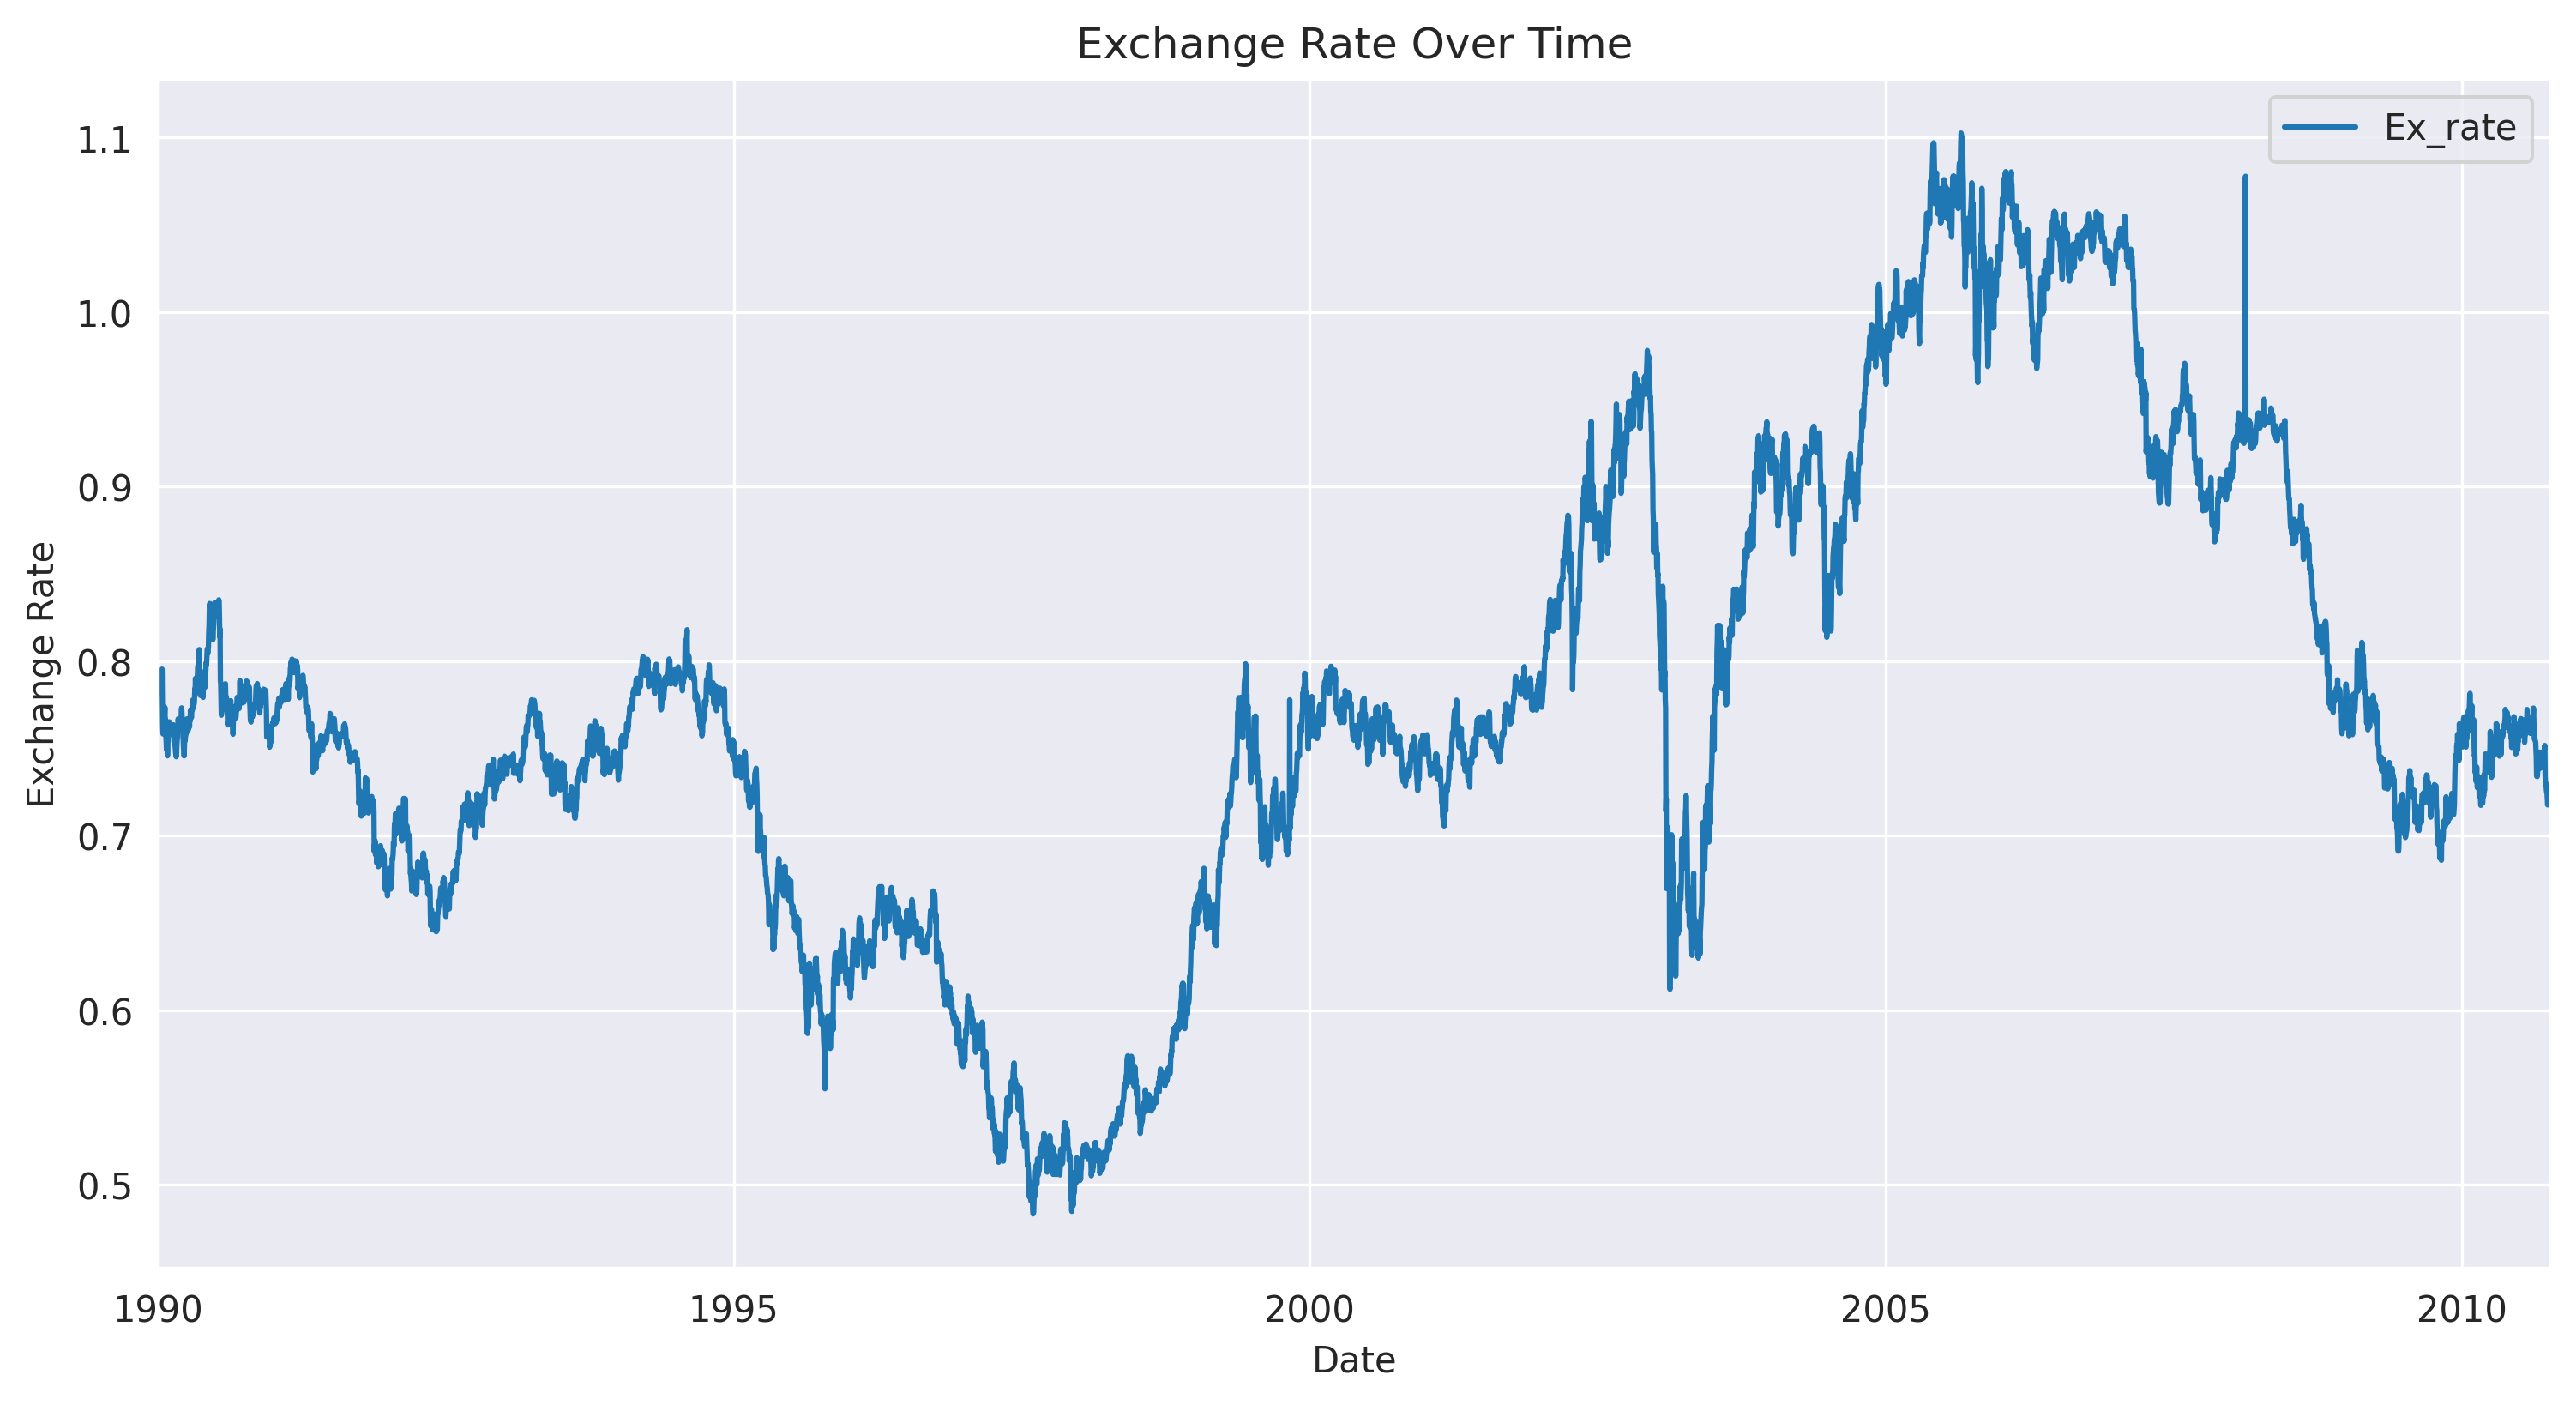

In [9]:
# Plot the original time series
df.plot(title='Exchange Rate Over Time', ylabel='Exchange Rate', xlabel='Date')
plt.show()

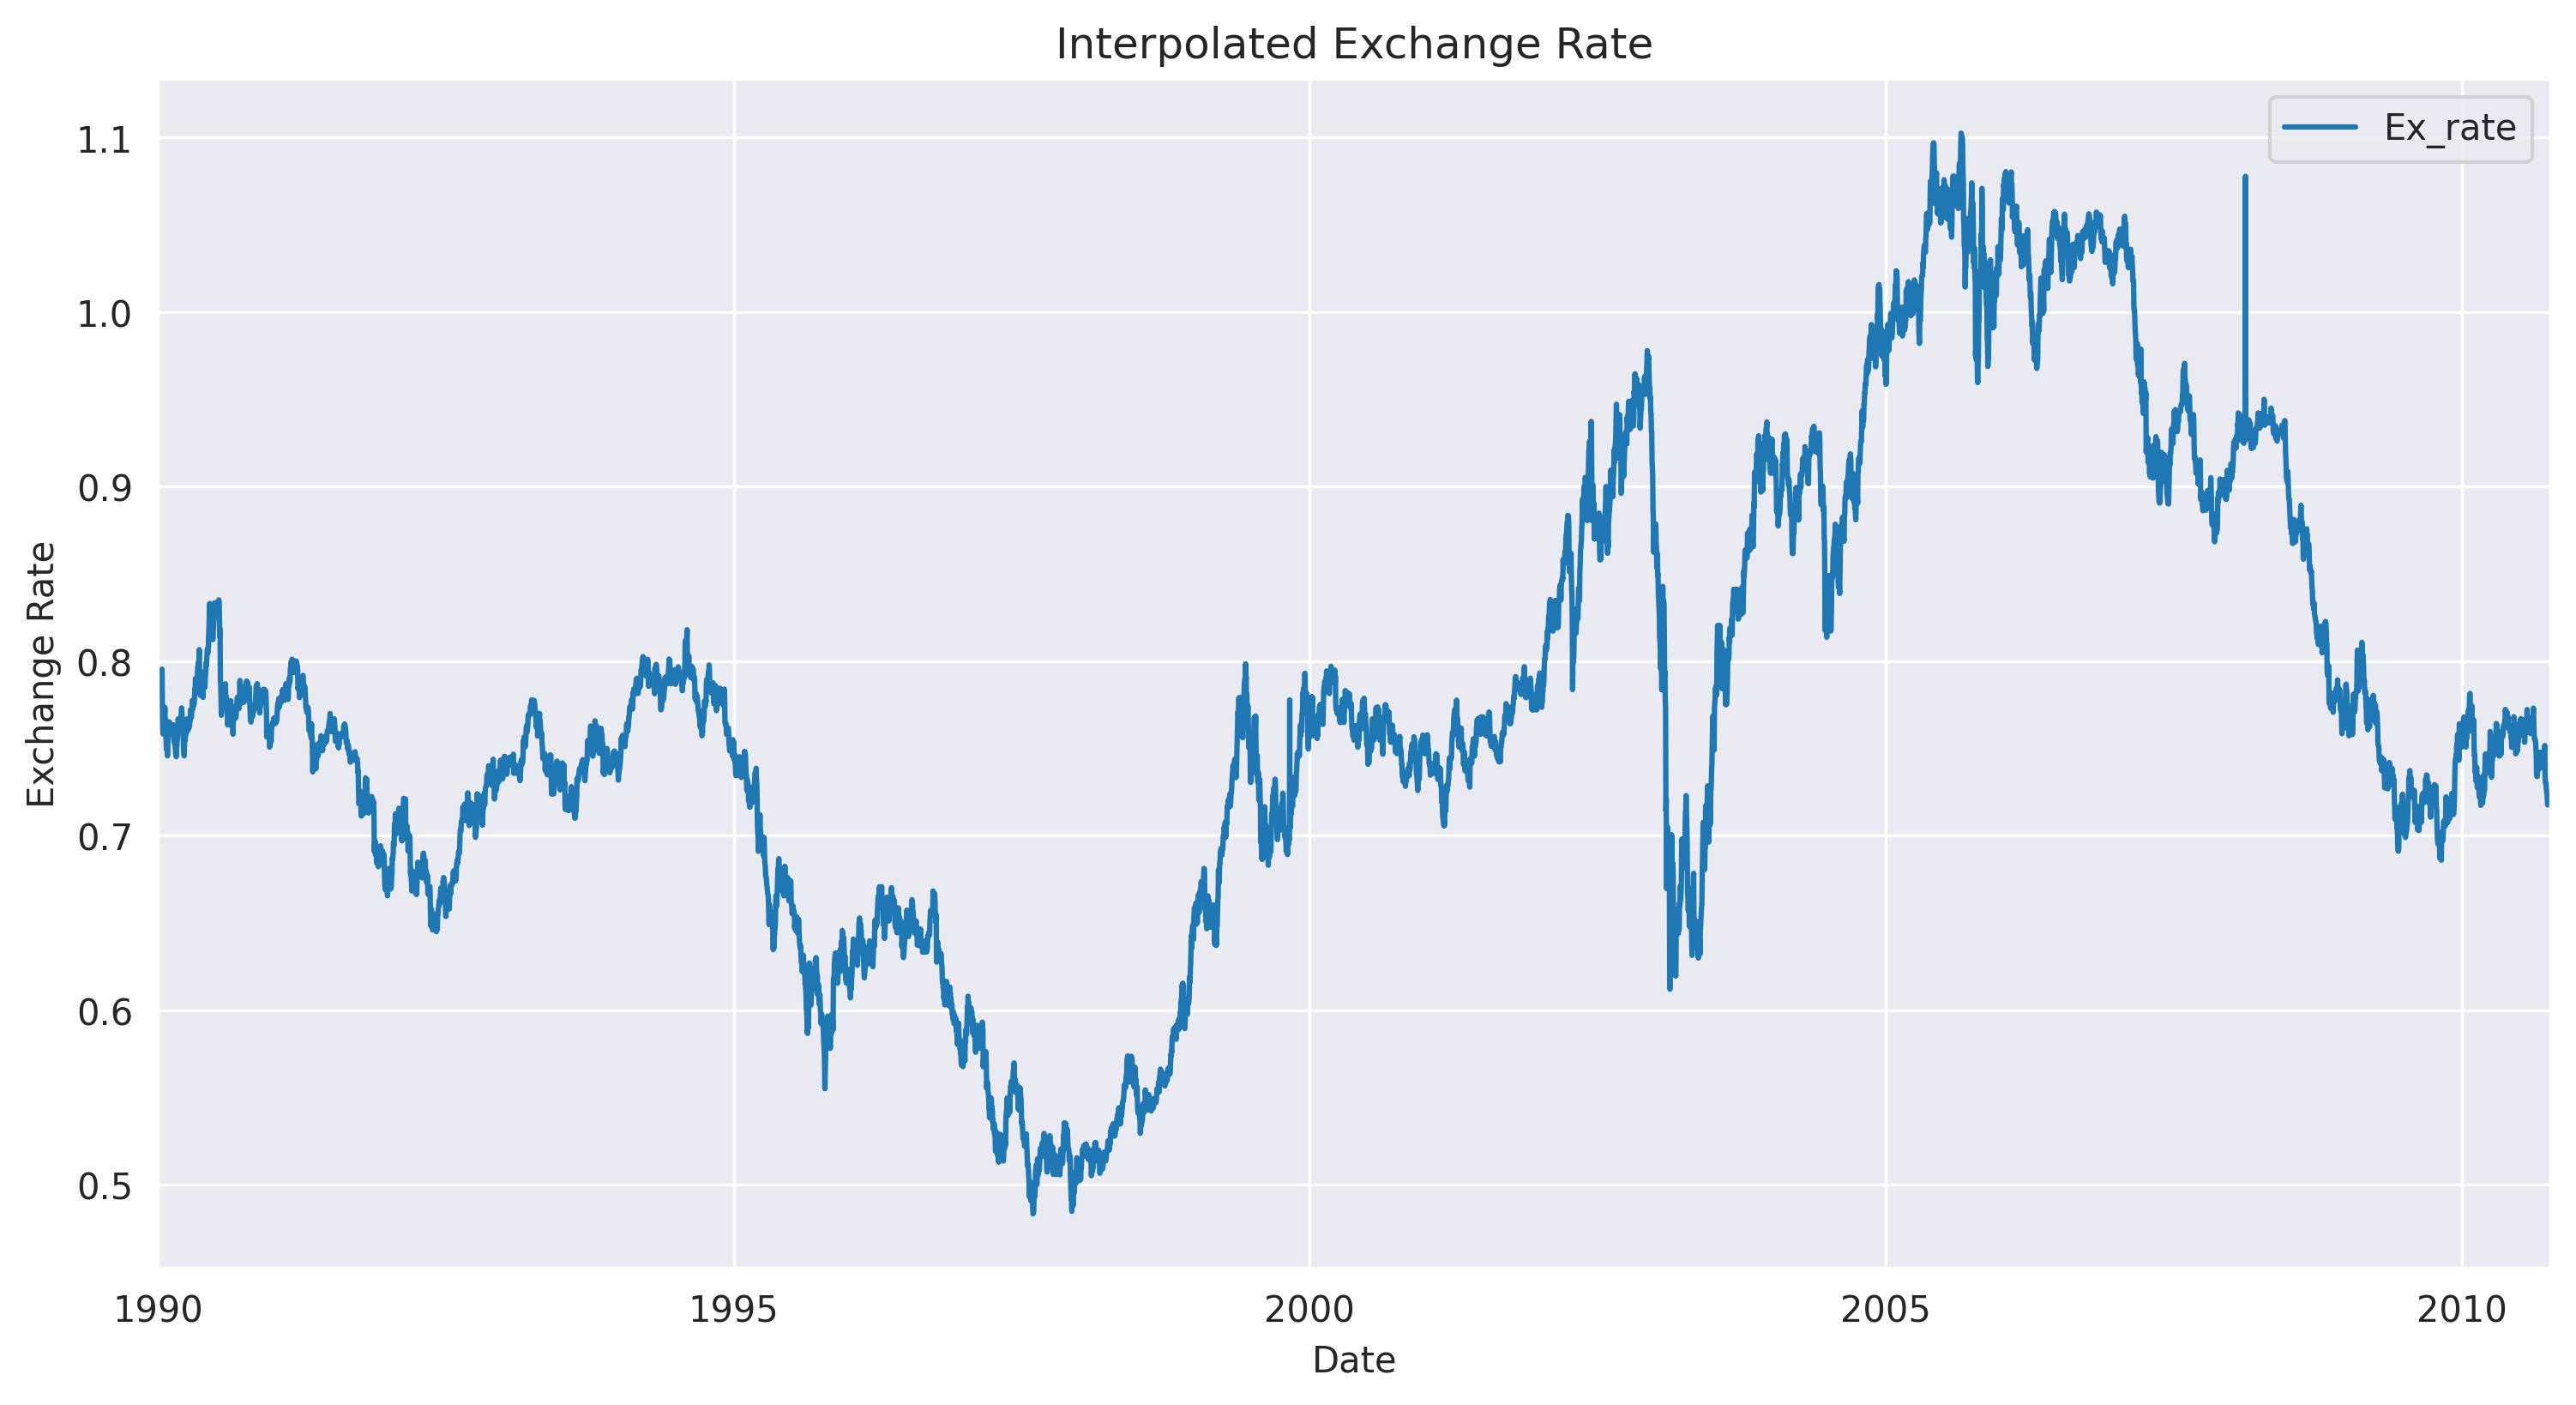

In [10]:
# Check for missing values and handle them by interpolation
upsampled = df.resample('D').mean()  # Resample daily
interpolated = upsampled.interpolate()  # Interpolate missing values
interpolated.plot(title='Interpolated Exchange Rate', ylabel='Exchange Rate', xlabel='Date')
plt.show()

In [11]:
# Check stationarity with the ADF test
adf_p_value = adfuller(interpolated['Ex_rate'])[1]
print(f"ADF Test P-Value: {adf_p_value}")

if adf_p_value < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


ADF Test P-Value: 0.4492327353597477
The time series is not stationary.


# Part 2: Model Building - ARIMA

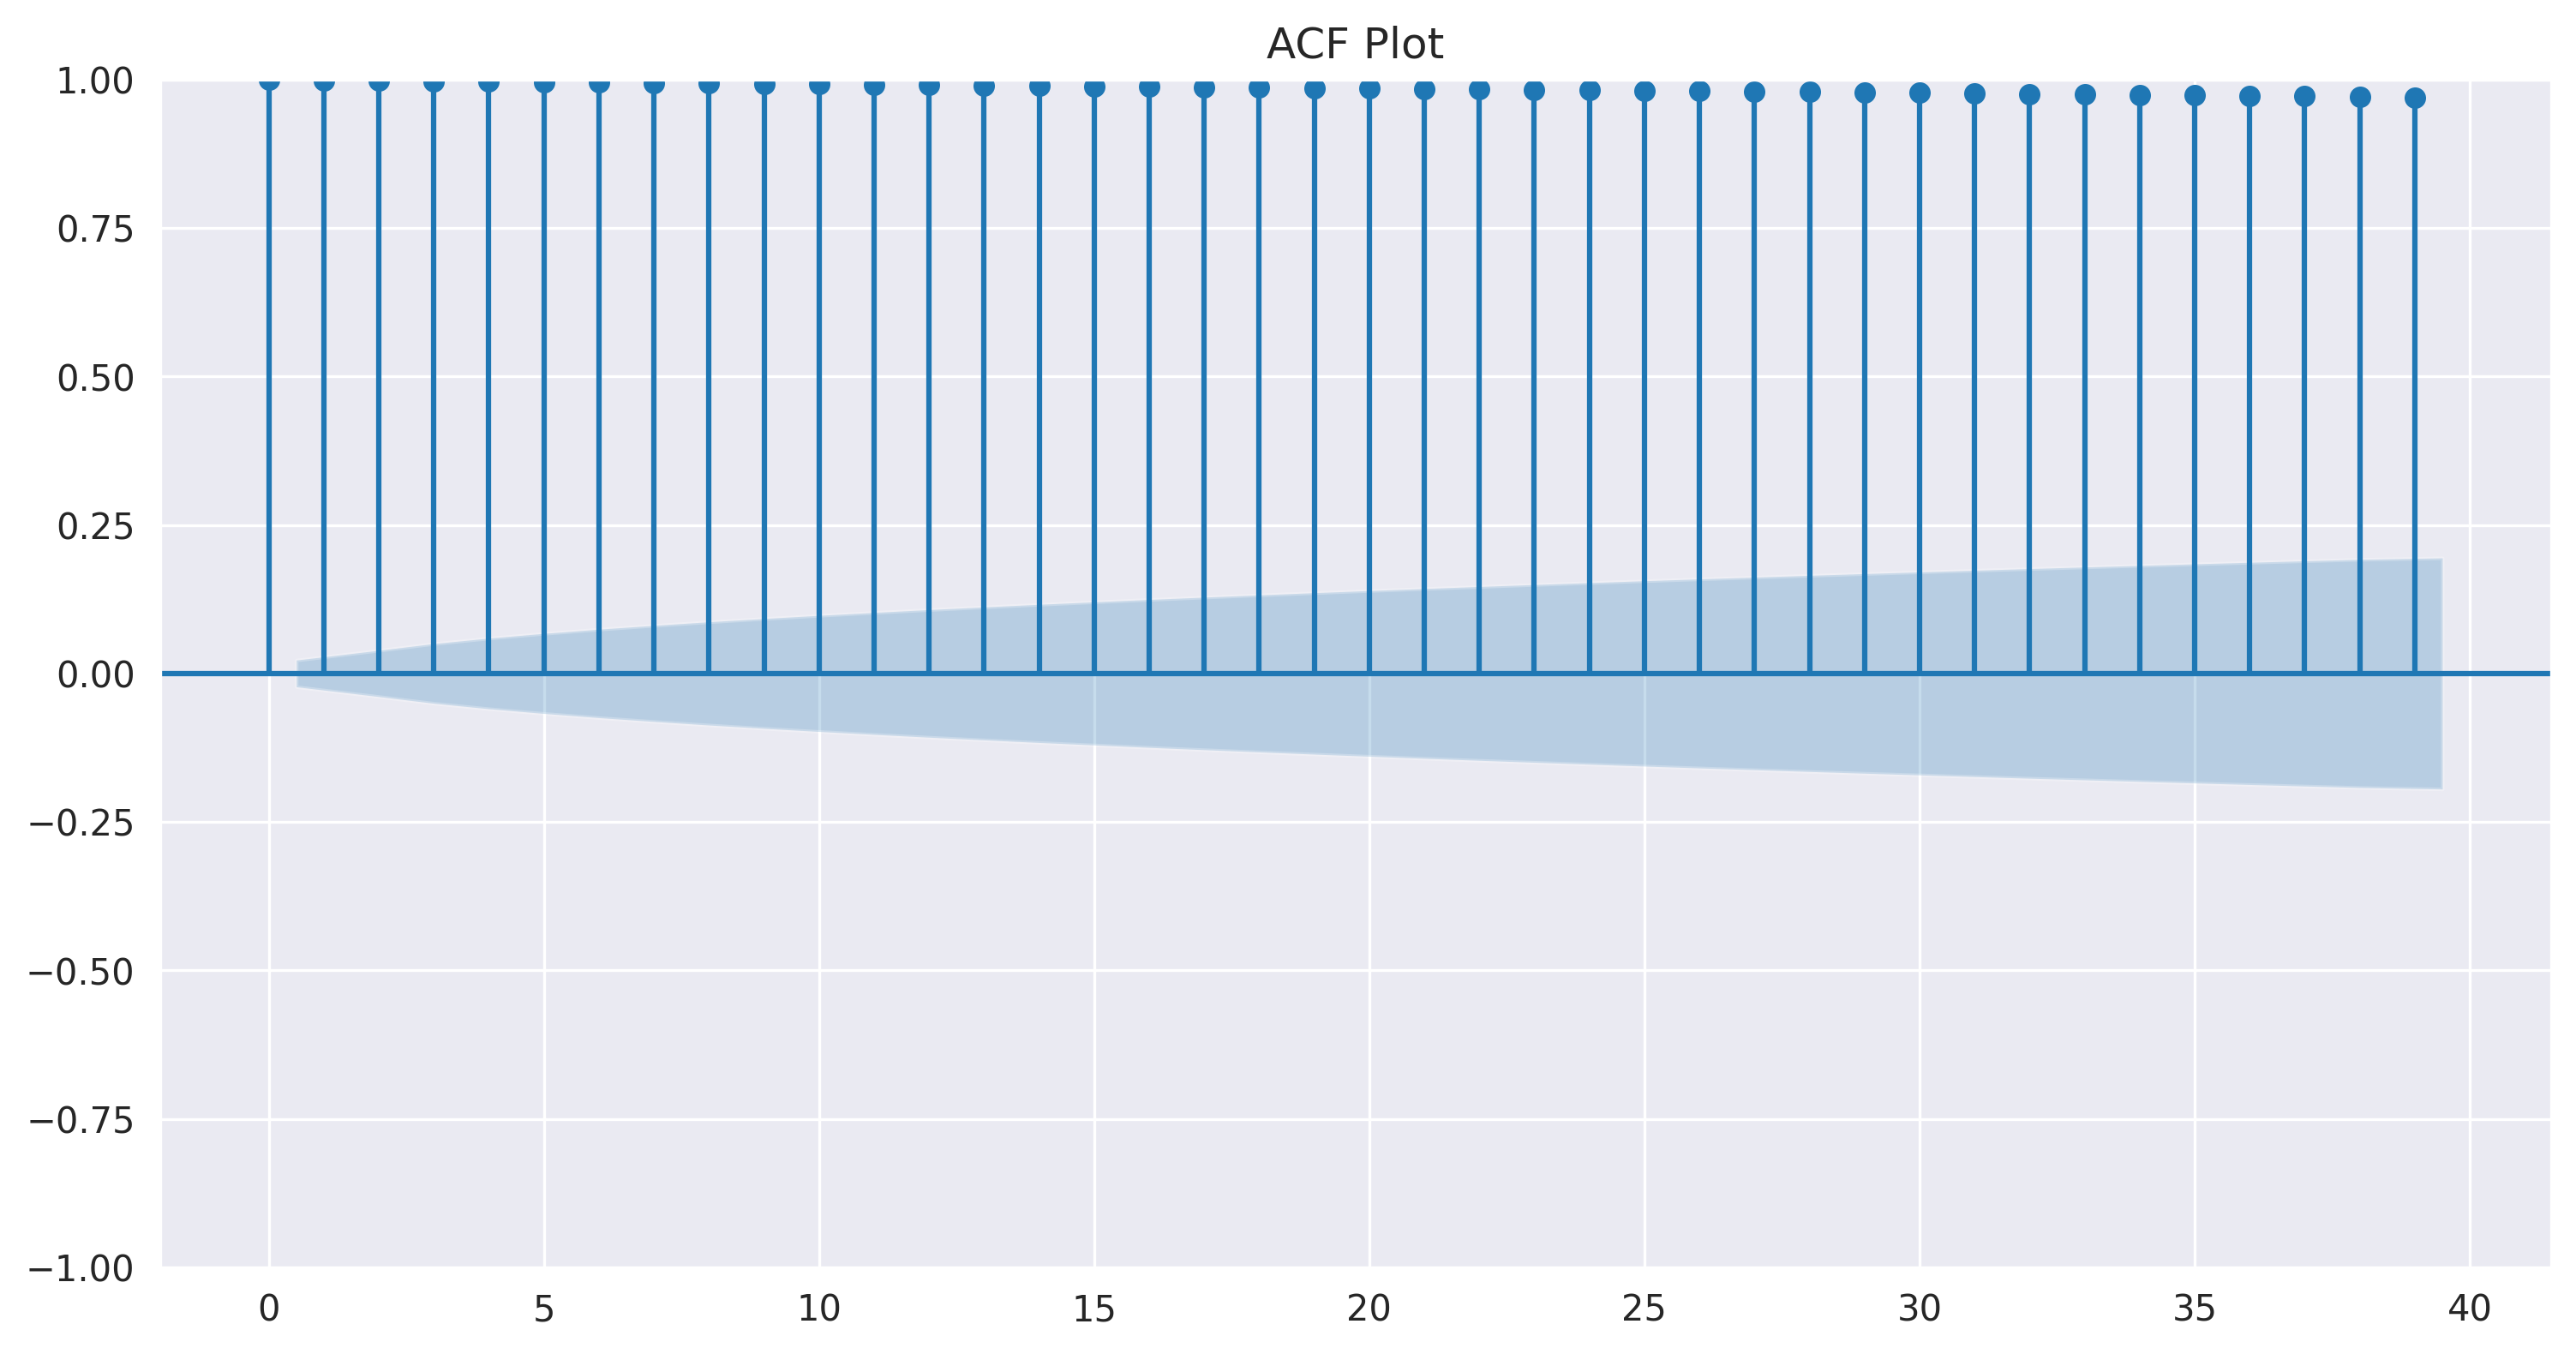

In [12]:
# ACF plots
plot_acf(interpolated['Ex_rate'])
plt.title("ACF Plot")
plt.show()

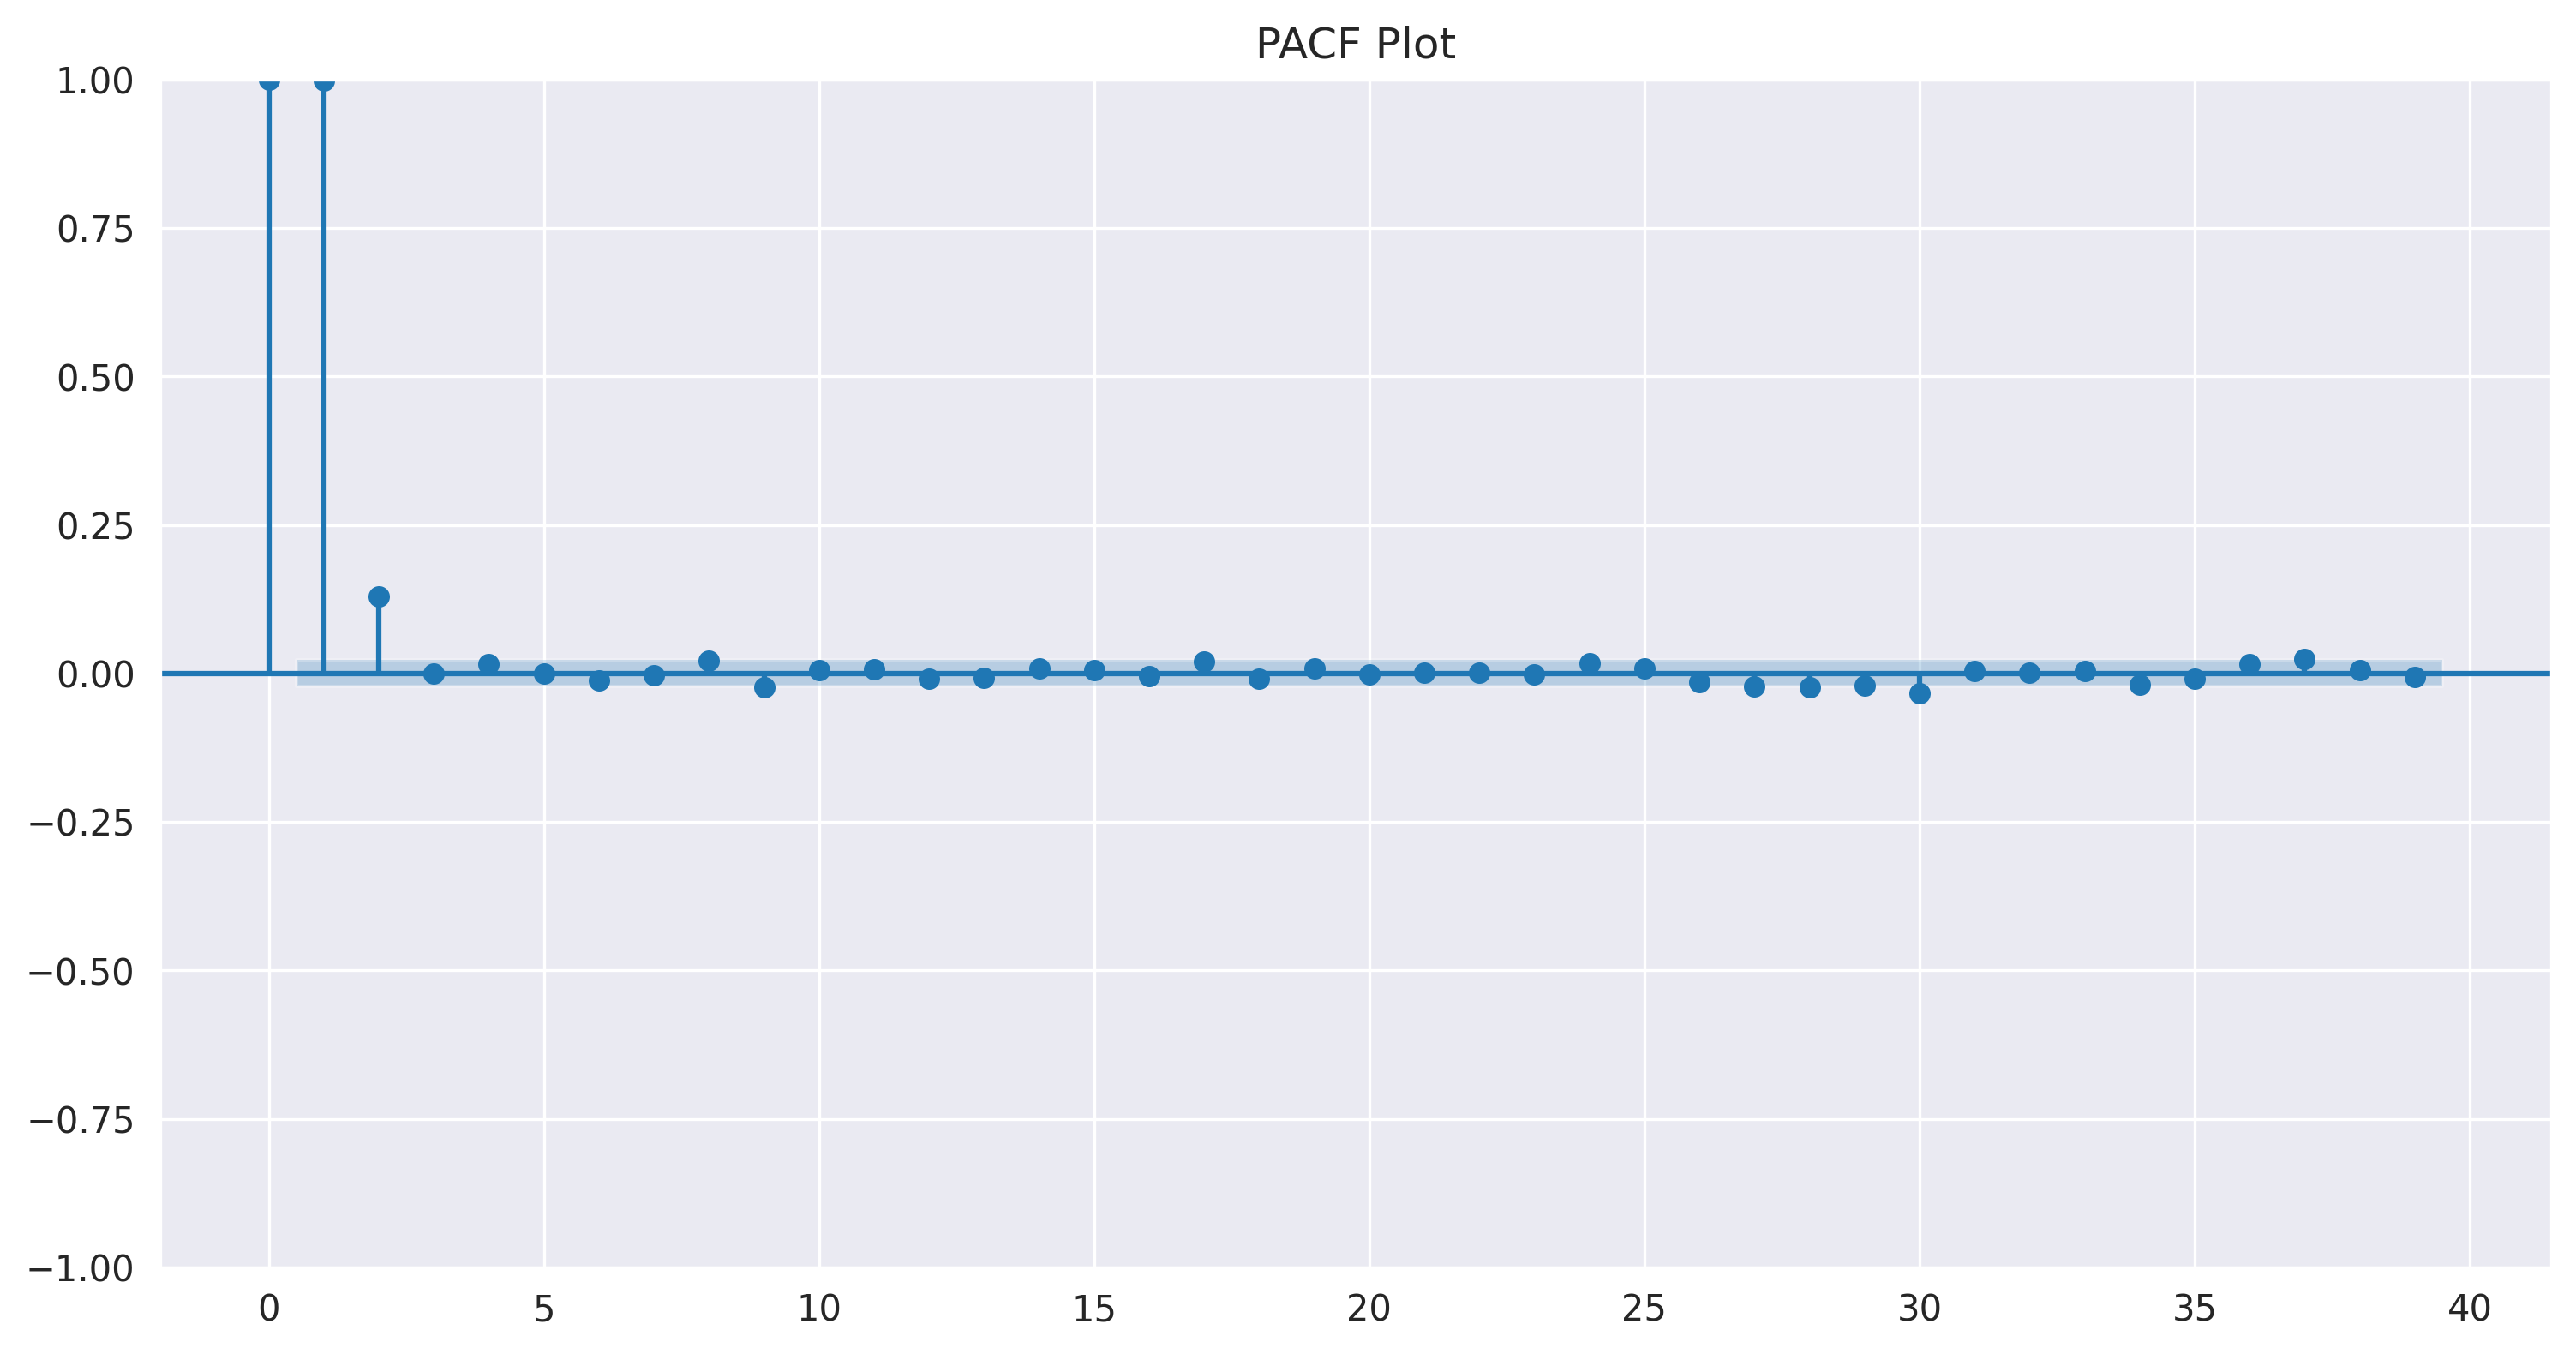

In [13]:
#PACF plots
plot_pacf(interpolated['Ex_rate'])
plt.title("PACF Plot")
plt.show()

In [14]:
# Automatic selection of ARIMA parameters using auto_arima
arima_model = auto_arima(interpolated['Ex_rate'], seasonal=False, trace=True)
print(f"Selected ARIMA Order: {arima_model.order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-56098.154, Time=7.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55972.211, Time=3.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56102.338, Time=2.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-56100.772, Time=13.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55974.195, Time=0.98 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56100.340, Time=3.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-56100.341, Time=2.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-56098.328, Time=6.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-56104.319, Time=0.57 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56102.321, Time=1.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-56102.322, Time=1.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-56102.753, Time=0.82 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-56100.315, Time=1.90 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 45.822 se

In [15]:
# Split data into train and test sets
train = interpolated.iloc[:-1800]
test = interpolated.iloc[-1800:]

In [16]:
# Fit ARIMA model
arima = ARIMA(train['Ex_rate'], order=arima_model.order).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 5788
Model:                 ARIMA(1, 1, 0)   Log Likelihood               21702.269
Date:                Sun, 24 Nov 2024   AIC                         -43400.538
Time:                        18:06:31   BIC                         -43387.212
Sample:                    01-01-1990   HQIC                        -43395.902
                         - 11-05-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0577      0.005    -11.476      0.000      -0.068      -0.048
sigma2      3.237e-05    1.8e-07    179.443      0.000     3.2e-05    3.27e-05
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [17]:
# Forecasting
forecast = arima.forecast(steps=len(test))
test['Forecast_ARIMA'] = forecast

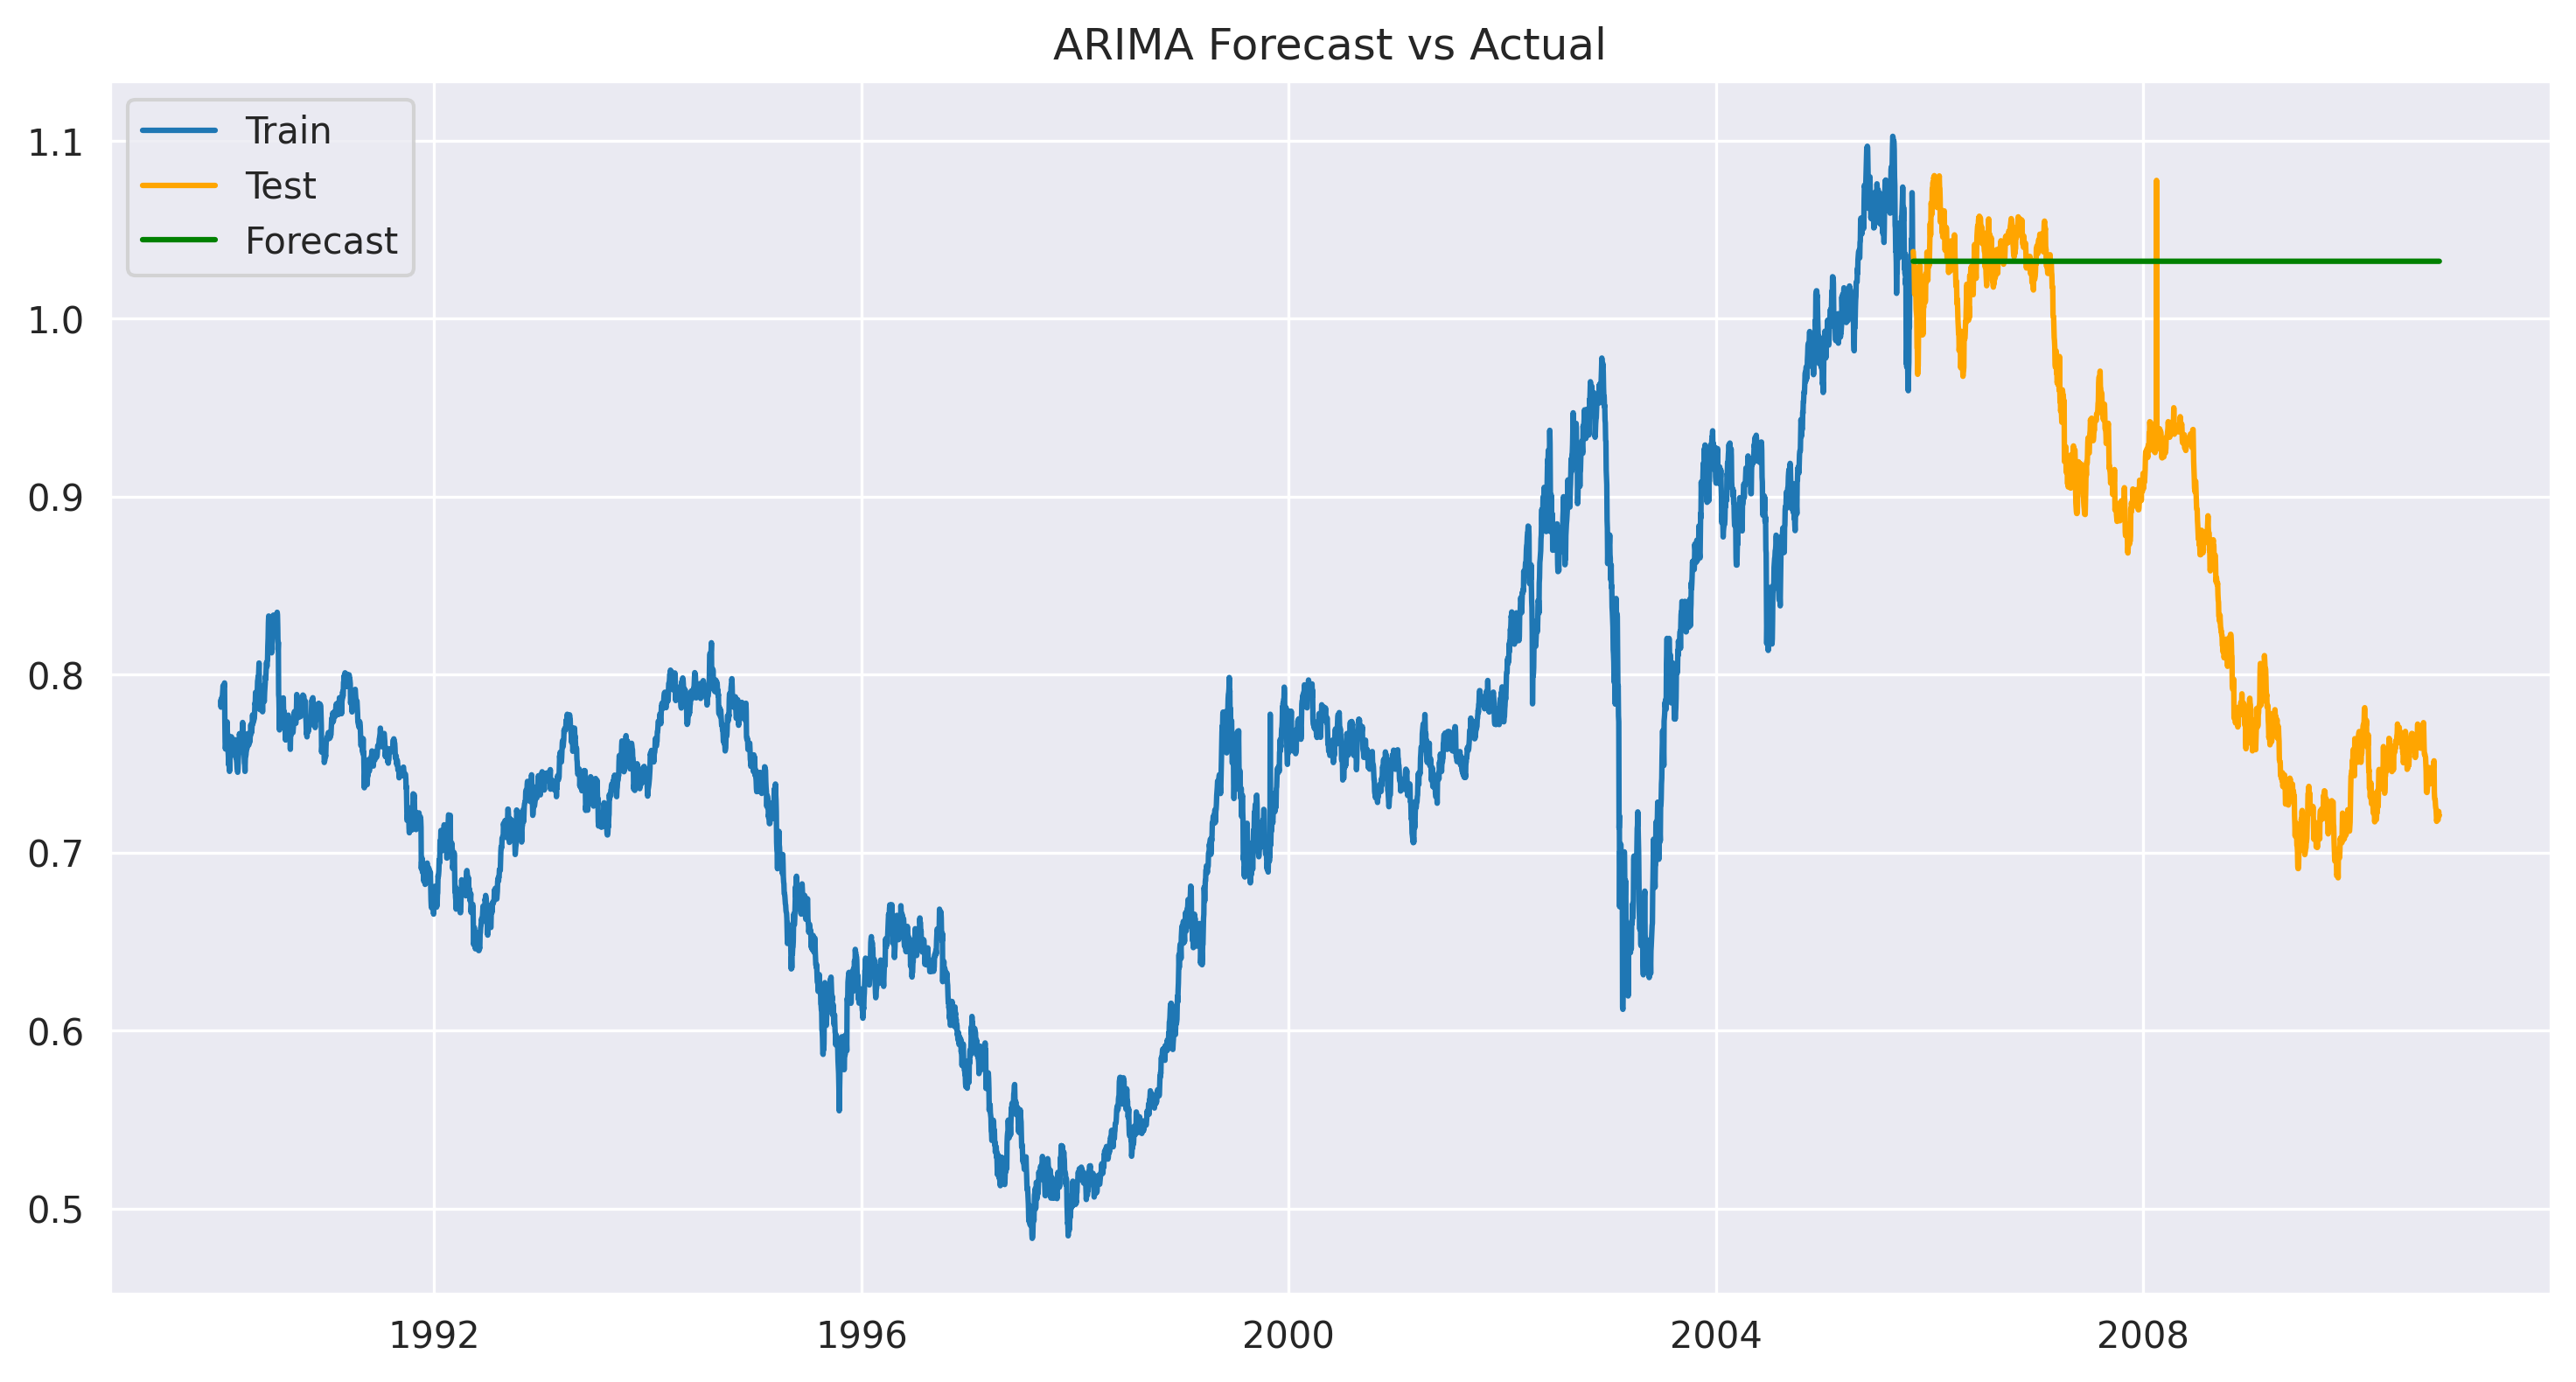

In [18]:
# Plot actual vs forecast
plt.plot(train['Ex_rate'], label='Train')
plt.plot(test['Ex_rate'], label='Test', color='orange')
plt.plot(test['Forecast_ARIMA'], label='Forecast', color='green')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

In [19]:
# Evaluation metrics
rmse_arima = np.sqrt(mean_squared_error(test['Ex_rate'], test['Forecast_ARIMA']))
mae_arima = mean_absolute_error(test['Ex_rate'], test['Forecast_ARIMA'])
print(f"ARIMA RMSE: {rmse_arima}")
print(f"ARIMA MAE: {mae_arima}")


ARIMA RMSE: 0.19572161115564787
ARIMA MAE: 0.15879452248342704


# Part 3: Model Building - Exponential Smoothing

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [21]:
# Fit an Exponential Smoothing model (Holt-Winters with trend)
exp_model = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal=None).fit()
forecast_exp = exp_model.forecast(steps=len(test))
test['Forecast_Exp'] = forecast_exp

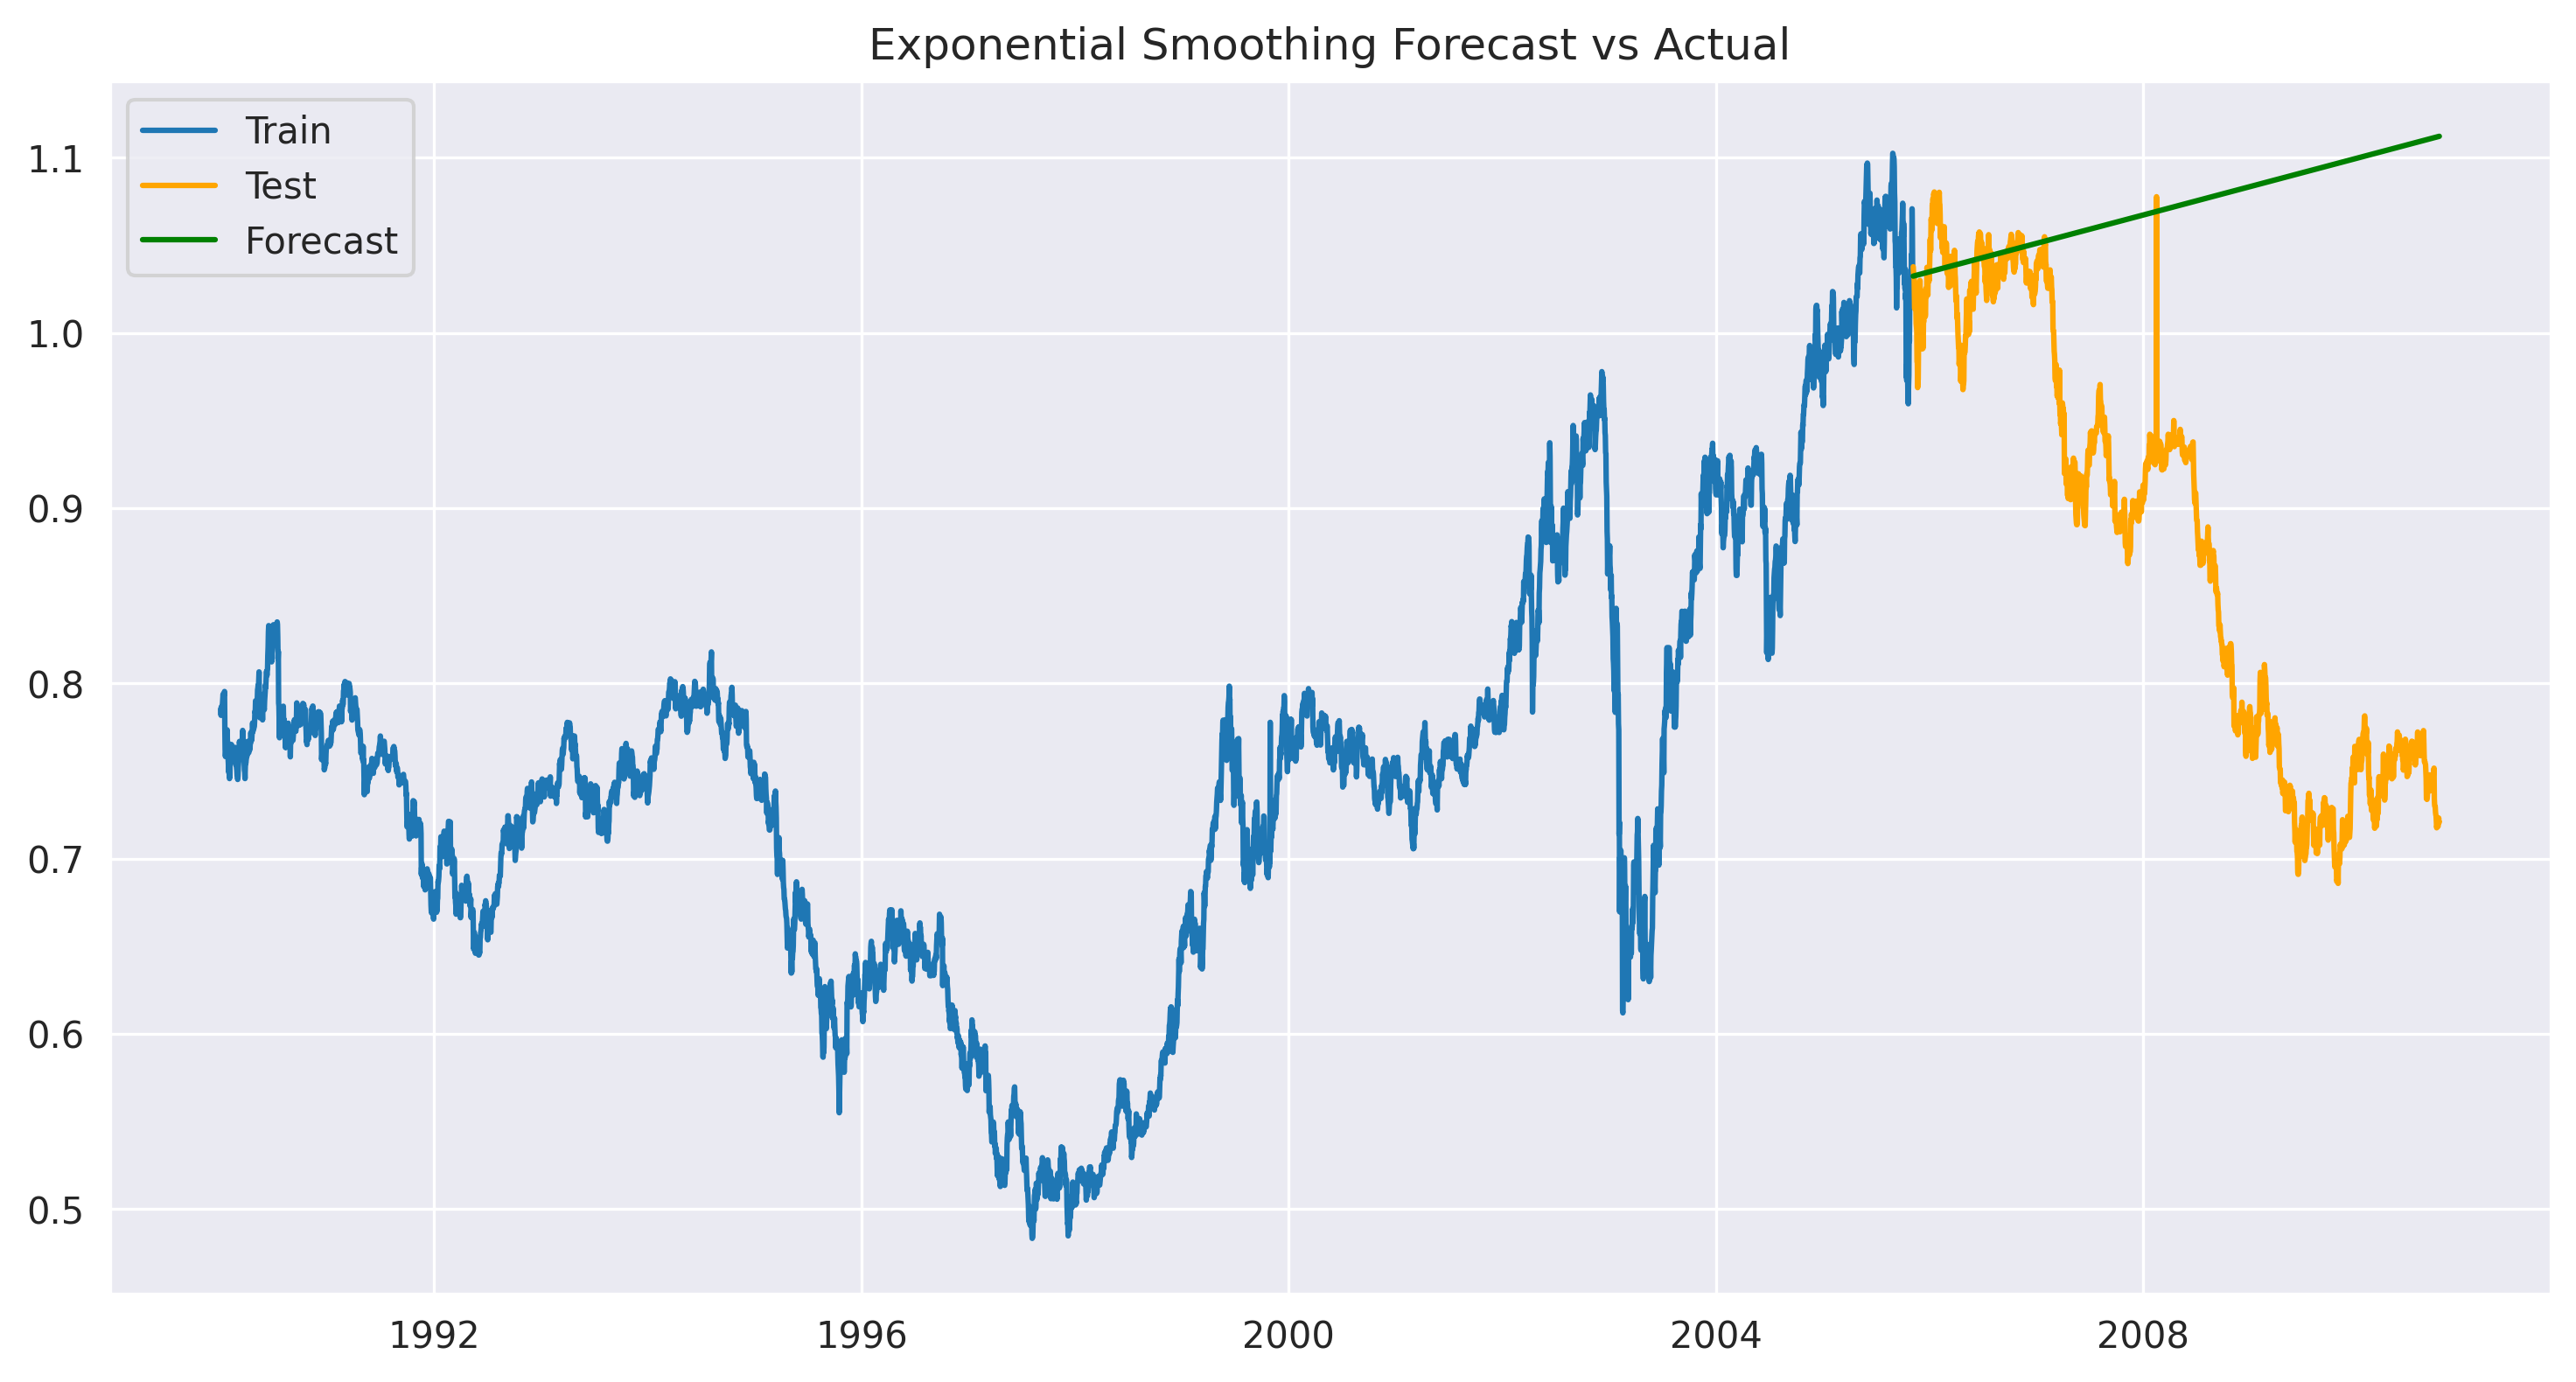

In [22]:
# Plot actual vs forecast
plt.plot(train['Ex_rate'], label='Train')
plt.plot(test['Ex_rate'], label='Test', color='orange')
plt.plot(test['Forecast_Exp'], label='Forecast', color='green')
plt.title('Exponential Smoothing Forecast vs Actual')
plt.legend()
plt.show()

In [23]:
# Evaluation metrics
rmse_exp = np.sqrt(mean_squared_error(test['Ex_rate'], test['Forecast_Exp']))
mae_exp = mean_absolute_error(test['Ex_rate'], test['Forecast_Exp'])
print(f"Exponential Smoothing RMSE: {rmse_exp}")
print(f"Exponential Smoothing MAE: {mae_exp}")


Exponential Smoothing RMSE: 0.24078320032533515
Exponential Smoothing MAE: 0.19631492372708073


# Part 4: Evaluation and Comparison

In [24]:
# Compare RMSE and MAE for both models
print("Model Evaluation Metrics:")
print(f"ARIMA - RMSE: {rmse_arima}, MAE: {mae_arima}")
print(f"Exponential Smoothing - RMSE: {rmse_exp}, MAE: {mae_exp}")

Model Evaluation Metrics:
ARIMA - RMSE: 0.19572161115564787, MAE: 0.15879452248342704
Exponential Smoothing - RMSE: 0.24078320032533515, MAE: 0.19631492372708073


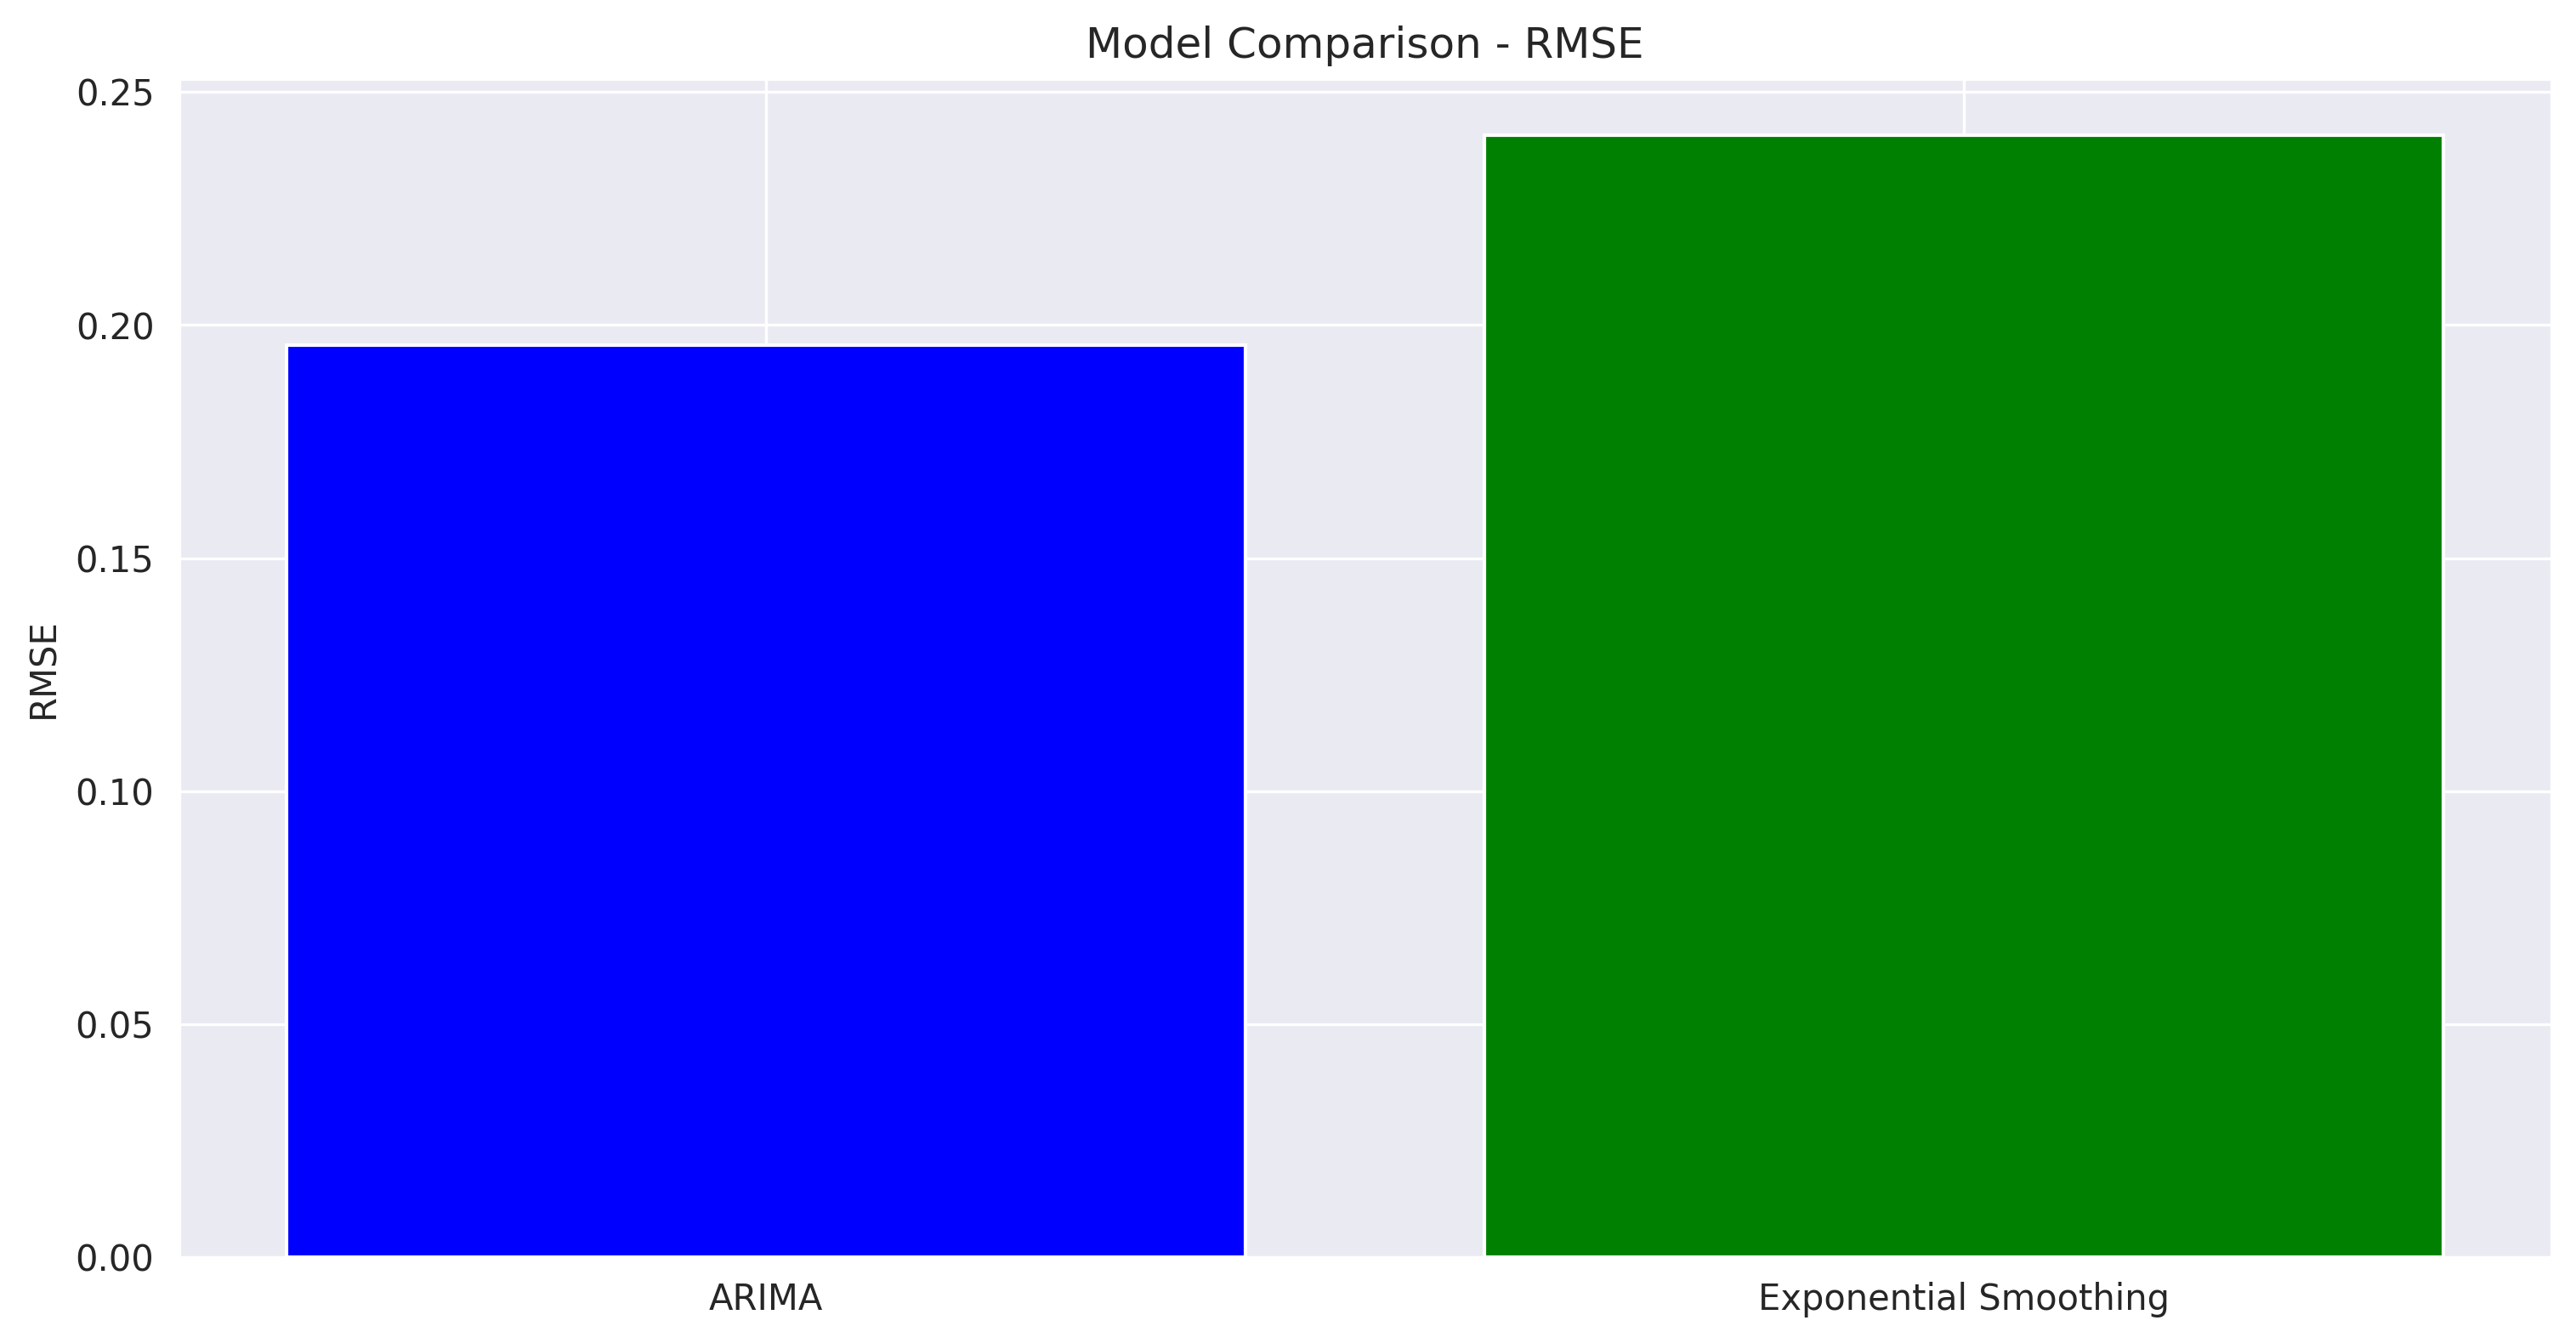

In [25]:
# Plot comparison
plt.bar(['ARIMA', 'Exponential Smoothing'], [rmse_arima, rmse_exp], color=['blue', 'green'])
plt.title('Model Comparison - RMSE')
plt.ylabel('RMSE')
plt.show()

# Interpretation

1) ARIMA Model:

* RMSE: 0.1957
* MAE: 0.1588

2) Exponential Smoothing Model:

* RMSE: 0.2408
* MAE: 0.1963

3) Key Observations:

- RMSE (Root Mean Squared Error):
- ARIMA has a lower RMSE (0.1957) compared to Exponential Smoothing (0.2408). A lower RMSE indicates that ARIMA’s predictions are closer to the actual values, with smaller errors, compared to Exponential Smoothing.

- MAE (Mean Absolute Error):
- Similarly, ARIMA has a lower MAE (0.1588) compared to Exponential Smoothing (0.1963). This suggests that, on average, the magnitude of the errors for ARIMA is smaller than for Exponential Smoothing.

** Conclusion:
- ARIMA outperforms Exponential Smoothing in both RMSE and MAE. Therefore, based on these metrics, ARIMA seems to provide more accurate predictions.